# Creating basin and river network with pysheds
## This code illustrated how to make a watershed or basin for a given point in a river directly using HydroSHEDS conditioned DEM and flow directions

In [5]:
# import necessary packages
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries
# set the font and font size for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

### Visualizing the downloaded and merged hydrologically conditioned DEM

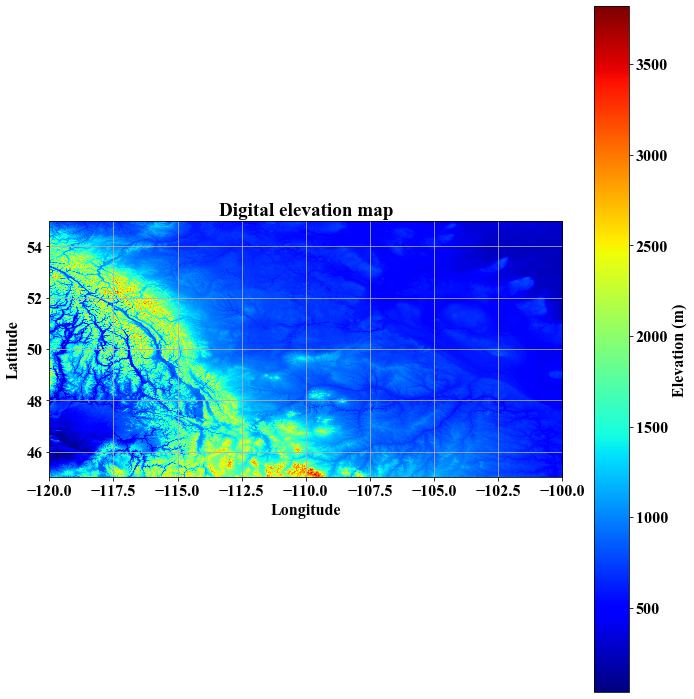

In [6]:
path = '/Users/shg096/Desktop/DEM_downloads/' # identifying the path to the folder that the contain the DEM folder
# read the bil or geotiff, the code reads the file and is in grid as declared name "dem"
grid = Grid.from_raster(path+'merged_DEM.tif', data_name='dem') # part of Missouri River

ID = np.where(grid.dem!=0) # the missing values is set to 0 removing them from min and max for colorbar
plt.figure(figsize = (10,10))
plt.imshow(grid.dem.astype(float), extent=grid.extent, cmap='jet', zorder=1,
           vmin=np.min(grid.dem[ID]), vmax=np.max(grid.dem[ID]))
plt.colorbar(label='Elevation (m)') # creating the colorbar and its name and unit
plt.grid(zorder=0) # creating the grid on the map
plt.title('Digital elevation map') # creating title
plt.xlabel('Longitude') #xlable which is long
plt.ylabel('Latitude') #ylable which is lat
plt.tight_layout()
plt.savefig(path+'conditioned_dem.png', bbox_inches='tight') # save the figure

### Visualizing the downloaded and merged flow direction

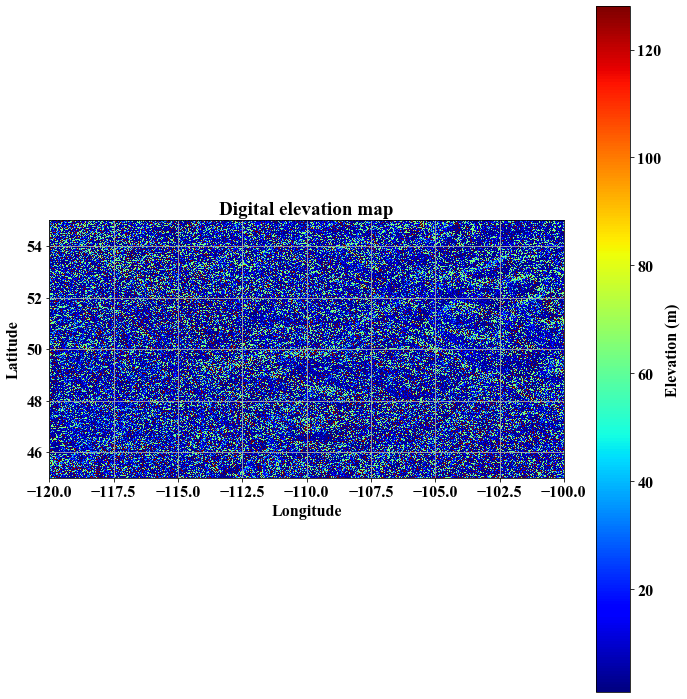

In [8]:
grid = Grid.from_raster(path+'merged_dir.tif', data_name='dir') # part of Missouri River

ID = np.where(grid.dir!=255) # the missing values is set to 255 removing them from min and max for colorbar
plt.figure(figsize = (10,10))
plt.imshow(grid.dir.astype(float), extent=grid.extent, cmap='jet', zorder=1,
           vmin=np.min(grid.dir[ID]), vmax=np.max(grid.dir[ID]))
plt.colorbar(label='Elevation (m)') # creating the colorbar and its name and unit
plt.grid(zorder=0) # creating the grid on the map
plt.title('Digital elevation map') # creating title
plt.xlabel('Longitude') #xlable which is long
plt.ylabel('Latitude') #ylable which is lat
plt.tight_layout()
plt.savefig(path+'conditioned_dir.png', bbox_inches='tight') # save the figure

## So far, we have all the neccessary raster to start basin or catchemtn deliniation

In [9]:
# Compute perliminary accumulation for snapping the gauges on the river network
grid.accumulation(data='dir', out_name='acc', nodata_in=255)

In [ ]:
# providing the coordinates of the basin outlet
x, y = -105.09790, 53.25160 # North Sask
#x, y = -105.07513, 53.22306 # South Sask
x, y = -104.08276, 53.30346 # Sask
#x, y = -106.87272, 51.27785 # Gardiner
#x, y = -107.65810, 50.49660 # 
#x, y = -112.12270, 51.15620 # Red Deer 
# x, y = -114.64317, 51.21428 # Bow after Ghoast Lake

xy = np.column_stack([x, y])

# putting the outlet point exactly on the river network
new_xy = grid.snap_to_mask(grid.acc > 10000, xy, return_dist=False)
new_xs, new_ys = new_xy[:,0], new_xy[:,1]
print(new_xs, new_ys)


# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
# Delineate the catchment
#grid.catchment(data='dir', x=new_xs, y=new_ys, out_name='catch',
#               recursionlimit=15000, xytype='label')

grid.catchment(data='dir', x=new_xs, y=new_ys, dirmap=dirmap, out_name='catch',nodata_in=255,
               recursionlimit=100000, xytype='label')

catch = grid.catch

grid.add_gridded_data(catch.astype(float), data_name='Basin_Entire', affine=grid.affine,
                     shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)
grid.to_raster('Basin_Entire', path+'Entire_Basin_Sask.tif', view=False)


# show the deliniated basin
plt.figure(figsize = (7,7))
plt.imshow(grid.catch.astype(int), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Masekd flow direction (-)')
plt.grid(zorder=0)
plt.title('Masekd flow direction map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

[-104.08333333] [53.30416667]


## Creating a shapefile that includes the entire basin

In [5]:
Basin_Entire = grid.catchment(new_xs, new_ys, \
                       data='dir', dirmap=dirmap, nodata_in=255, xytype='label', recursionlimit=50000)
Basin_Entire = (Basin_Entire != 0).astype(int)
grid.add_gridded_data(Basin_Entire.astype(float), data_name='Basin_Entire', affine=grid.affine,
                     shape=grid.dem.shape, crs=grid.crs, nodata=np.nan)
grid.to_raster('Basin_Entire', path+'Entire_Basin.tif', view=False)

# show the deliniated basin
plt.figure(figsize = (7,7))
plt.imshow(grid.Basin_Entire.astype(int), extent=grid.extent, cmap='jet')#, zorder=1)
# plt.colorbar(label='Basin (-)')
plt.grid(zorder=0)
plt.title('Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# putting into the shapefile
from osgeo import gdal, ogr
# this allows GDAL to throw Python Exceptions
#gdal.UseExceptions()
src_ds = gdal.Open( path+'Entire_Basin.tif' )
srcband = src_ds.GetRasterBand(1)
dst_layername = path+'Entire_Basin.shp'
drv = ogr.GetDriverByName('ESRI Shapefile')
dst_ds = drv.CreateDataSource(dst_layername)
dst_layer = dst_ds.CreateLayer(dst_layername , srs=None)
fd = ogr.FieldDefn('DN', ogr.OFTInteger)
dst_layer.CreateField(fd)
dst_field = dst_layer.GetLayerDefn().GetFieldIndex('DN')
gdal.Polygonize(srcband, None, dst_layer, dst_field, [], callback=None)

AttributeError: 'bool' object has no attribute 'astype'